In [58]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.constants import c, hbar, m_n, M_sun
from astropy import units as u

from scipy.integrate import odeint, solve_ivp

# Non Relativistic (k_F << m)

In [59]:
#----------------------------
#Define the parameters
#----------------------------

AZ = 1
K_nonrel = (hbar ** 2 / 15 / np.pi**2 / m_n * ((3 * np.pi**2)/ (m_n * c**2 * AZ)) **(5/3)).to('cm2 / erg**(2/3)')
gamma = 5/3
R0 = 1.473 * u.km

alpha = 1 * u.km

e_0 = (( (R0 / alpha) ** gamma / K_nonrel ) **( 1/(gamma-1))).to('erg/cm3')

beta = (4 * np.pi * e_0 / (M_sun * c**2 * (K_nonrel * e_0 **(gamma-1))**(1/gamma))).to('1/km3')
    
K = K_nonrel * (e_0 **(gamma-1))

lambda0 = (4 * np.pi * e_0 / c**2 / M_sun).to('1/km3')

print('K:', K)
print('beta:', beta)
print('K_nonrel:', K_nonrel.to('cm2 / erg**(2/3)'))
print('lambda:', lambda0)


K: 1.906943876256988
beta: 0.7713646930453346 1 / km3
K_nonrel: 6.427932009448279e-26 cm2 / erg(2/3)
lambda: 1.1362201928557767 1 / km3


In [60]:
#-------------------------
#Estimate central pressure
#-------------------------

M = 1 * M_sun
R = 10 * u.km
P_c_units = (K_nonrel * ( (3 * M * c**2) / (4 * np.pi * R**3) )**gamma).to('erg/cm3')

P_c = P_c_units / e_0
print(f'Central pressure for M={M:.2e}, R={R}: P_c={P_c:.2}')
print('Energy density unit:', e_0)


Central pressure for M=1.99e+30 kg, R=10.0 km: P_c=9.6e-05
Energy density unit: 1.6158459552580226e+38 erg / cm3


Basically Central pressure P_c = 1e-4

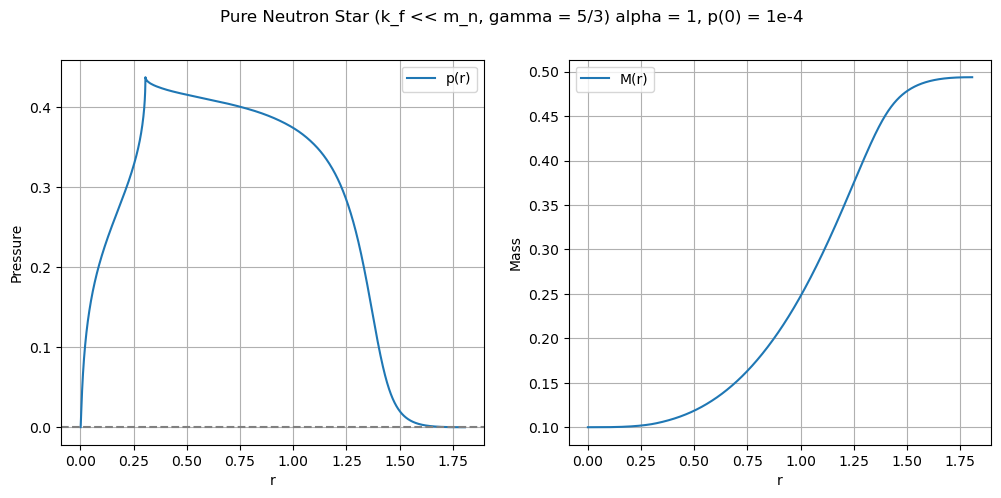

R = 1.80658555517111 km
M(R) = 0.49374413852913535 solar masses
p(R)= -2.6956595828713697e-09 almost zero


In [61]:
#-----------------------
#Define the ODE system
#-----------------------


def TOV(r, x):
    p, M = x
    if p <= 0:
        return [0, 0]

    term1 = alpha.value * M * p**(1 / gamma) / r**2
    term2 = 1 - (K * p ** (gamma - 1) ** (1 / gamma))
    term3 = 1 + lambda0.value * p * r**3 / M
    term4 = 1 - 2 * R0.value * M / r

    # Add a small epsilon to term4 to avoid division by zero
    epsilon = 1e-10
    dpdr = -term1 * term2 * term3 / (term4 + epsilon)
    dMdr = beta.value * r**2 * p**(1 / gamma)
    return [dpdr, dMdr]


#-----------------------
#Solve
#-----------------------

x_init = [1e-4, 0.1]
r_span = (0.001, 100)  #Integration range
r_eval = np.linspace(0.001, 100, 500000) #Points where solution is evaluated


sol = solve_ivp(TOV, r_span, x_init, t_eval=r_eval, method='LSODA')


r = sol.t
p = sol.y[0]
M = sol.y[1]


idx = np.where(p<=0)[0] # array amb els índexs on p<=0
if len(idx) > 0: 
    cutoff = idx[0]
    r = r[:cutoff+1]
    p = p[:cutoff+1]
    M = M[:cutoff+1]

#-----------------------
#Plot results
#-----------------------


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(r, p, label="p(r)")
ax1.axhline(0, color="gray", linestyle="--")
ax1.set_xlabel('r')
ax1.set_ylabel('Pressure')
ax1.legend()
ax1.grid()


ax2.plot(r, M, label="M(r)")
ax2.set_xlabel('r')
ax2.set_ylabel('Mass')
ax2.grid()
ax2.legend()

fig.suptitle('Pure Neutron Star (k_f << m_n, gamma = 5/3) alpha = 1, p(0) = 1e-4')

plt.show()


print("R =", r[-1], 'km')
print("M(R) =", M[-1], 'solar masses')
print('p(R)=',p[-1], 'almost zero')




# Relativistic (k_F >> m)

In [97]:
#----------------------------
#Define the parameters
#----------------------------

K_rel = 1.00 / 3.00
gamma = 1.00
R0 = (G * M_sun / c**2).to(u.km)  

alpha = 3 * R0

beta_ntrn =( 12 * np.pi / c ** 2 / M_sun * e_0).to('1/km3')
   
K = K_rel 

lambda0 = beta_ntrn  / 3

print('K:', K)
print('beta:', beta_ntrn)
print('lambda:', lambda0)


K: 0.3333333333333333
beta: 3.4086605785673303 1 / km3
lambda: 1.1362201928557767 1 / km3


In [72]:
#-------------------------
#Estimate central pressure
#-------------------------

M = 1 * M_sun
R = 10 * u.km
P_c_units = (K_rel * ( (3 * M * c**2) / (4 * np.pi * R**3) )**gamma).to('erg/cm3')

P_c = P_c_units / e_0
print(f'Central pressure for M={M:.2e}, R={R}: P_c={P_c:.2}')
print('Energy density unit:', e_0)


Central pressure for M=1.99e+30 kg, R=10.0 km: P_c=0.00088
Energy density unit: 1.6158459552580226e+38 erg / cm3


Central pressure P_c = 1e-3

Pc=1.0e-04 Pa -> R=1.000 km, M=0.0000 1 / kg M_sun


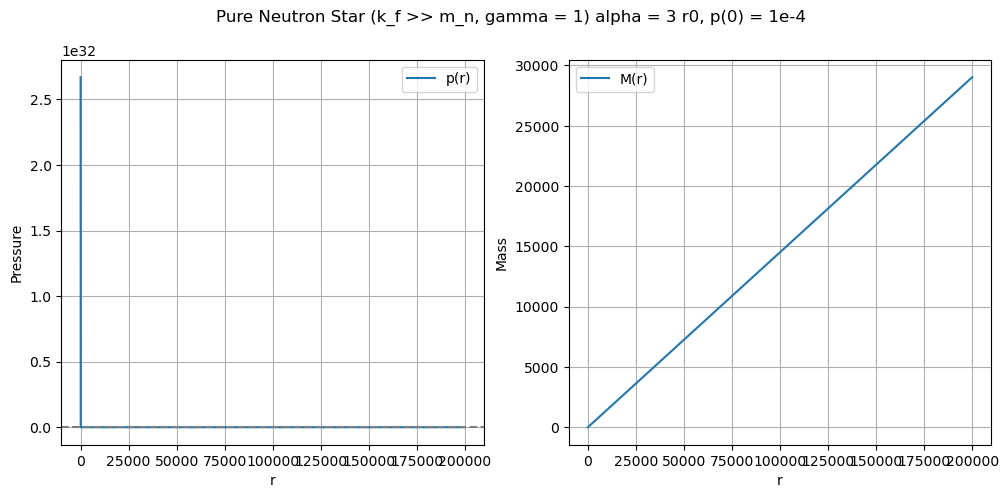

R = 200000.0 km
M(R) = 29023.700814153806 solar masses
p(R)= 1.7198055153560442e+16


In [110]:
#-----------------------
#Define the ODE system
#-----------------------


def TOV(r, x):
    p, M = x
    if p <= 0:
        return [0.0, 0.0]

    term1 = alpha.value * M * p / r**2
    term2 = 4 / 3
    term3 = 1 + lambda0.value * p * r**3 / M
    denom = 1 - 2 * R0.value * M / r

    if denom <= 0:
        return [0.0, 0.0]
    dpdr = -term1 * term2 * term3 / denom
    dMdr = beta.value * r**2 * p 
    return [dpdr, dMdr]

def stop_at_zero_pressure(r, y):
    return y[0]
stop_at_zero_pressure.terminal = True
stop_at_zero_pressure.direction = -1


#-----------------------
#Solve
#-----------------------
Pc = 1e-4
r0 = 1e-3
m0 = (4.0/3.0 * np.pi * r0**3 * (u.km)**3 * (3.0* Pc * u.erg / (u.cm) **3 /c**2)) / M_sun
rmax = 1000

x_init = [Pc, m0.value]
r_span = (r0, rmax)  #Integration range
r_eval = np.linspace(r0, rmax, 5000) #Points where solution is evaluated



sol = solve_ivp(TOV,  r_span, x_init, t_eval=r_eval, events=stop_at_zero_pressure, max_step=100.0, rtol=1e-6, atol=1e-8)

if sol.t_events[0].size > 0:
        Rsurf = sol.t_events[0][0]
else:
        Rsurf = sol.t[-1]
Mfinal = sol.y[1, -1]

print(f"Pc={Pc:.1e} Pa -> R={Rsurf/1000:.3f} km, M={Mfinal/M_sun:.4f} M_sun")


#-----------------------
#Plot results
#-----------------------


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(r, p, label="p(r)")
ax1.axhline(0, color="gray", linestyle="--")
ax1.set_xlabel('r')
ax1.set_ylabel('Pressure')
ax1.legend()
ax1.grid()


ax2.plot(r, M, label="M(r)")
ax2.set_xlabel('r')
ax2.set_ylabel('Mass')
ax2.grid()
ax2.legend()

fig.suptitle('Pure Neutron Star (k_f >> m_n, gamma = 1) alpha = 3 r0, p(0) = 1e-4')

plt.show()


print("R =", r[-1], 'km')
print("M(R) =", M[-1], 'solar masses')
print('p(R)=',p[-1])




In [111]:
m0

<Quantity 7.03173585e-60 km3 s2 erg / (kg m2 cm3)>

Pc=1.0e+33 Pa -> R=200.000 km, M=32.1987 M_sun
Pc=1.0e+34 Pa -> R=200.000 km, M=27.9686 M_sun
Pc=1.0e+35 Pa -> R=200.000 km, M=28.7296 M_sun
Pc=5.0e+35 Pa -> R=200.000 km, M=29.3061 M_sun


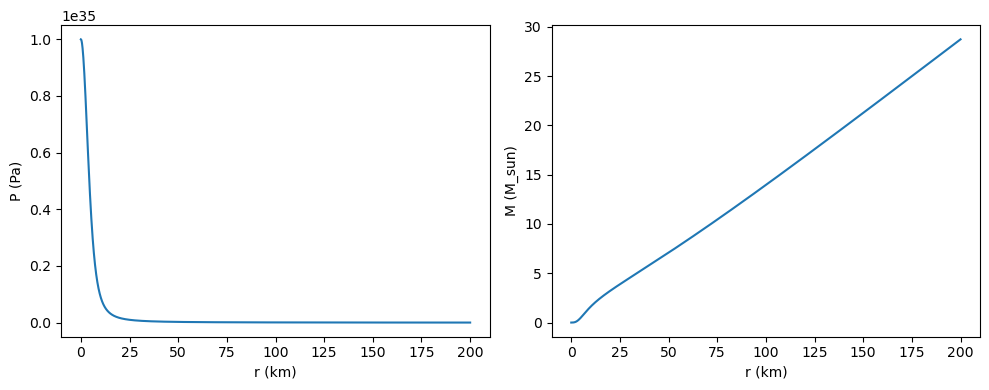

In [89]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy import constants as sc
import matplotlib.pyplot as plt

G = sc.G
c = sc.c
M_sun = 1.98847e30  # kg

# TOV rhs in SI units, EOS: eps = 3 * P
def tov_rhs(r, y):
    P, m = y
    if P <= 0:
        return [0.0, 0.0]
    eps = 3.0 * P
    rho = eps / c**2
    dmdr = 4.0 * np.pi * r**2 * rho
    denom = r**2 * (1.0 - 2.0 * G * m / (r * c**2))
    if denom <= 0:
        return [0.0, 0.0]
    dPdr = - G * (rho + P / c**2) * (m + 4.0 * np.pi * r**3 * P / c**2) / denom
    return [dPdr, dmdr]

def stop_at_zero_pressure(r, y):
    return y[0]
stop_at_zero_pressure.terminal = True
stop_at_zero_pressure.direction = -1

# Example central pressures (Pa)
central_pressures = [1e33, 1e34, 1e35, 5e35]
results = []
for Pc in central_pressures:
    r0 = 1.0  # start at 1 m
    # small-r mass approximation
    m0 = 4.0/3.0 * np.pi * r0**3 * (3.0*Pc/c**2)
    y0 = [Pc, m0]
    rmax = 2e5  # 200 km
    sol = solve_ivp(tov_rhs, (r0, rmax), y0, events=stop_at_zero_pressure, max_step=100.0, rtol=1e-6, atol=1e-8)
    if sol.t_events[0].size > 0:
        Rsurf = sol.t_events[0][0]
    else:
        Rsurf = sol.t[-1]
    Mfinal = sol.y[1, -1]
    results.append((Pc, Rsurf, Mfinal, sol))
    print(f"Pc={Pc:.1e} Pa -> R={Rsurf/1000:.3f} km, M={Mfinal/M_sun:.4f} M_sun")

# Plot example for Pc = 1e35 Pa
Pc = 1e35
sol = results[2][3]  # the sol object
r = sol.t; P = sol.y[0]; M = sol.y[1]
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(r/1000, P); plt.xlabel('r (km)'); plt.ylabel('P (Pa)')
plt.subplot(1,2,2); plt.plot(r/1000, M/M_sun); plt.xlabel('r (km)'); plt.ylabel('M (M_sun)')
plt.tight_layout()
plt.show()



R0 = 1.476625038050125 km
alpha = 4.4298751141503745 km
lambda0 = 7.031735848076818e-29 1 / (Pa km3)
beta = 2.1095207544230455e-28 1 / (Pa km3)
Pc_example (kF=1 fm^-1) = 2.669e+32 Pa


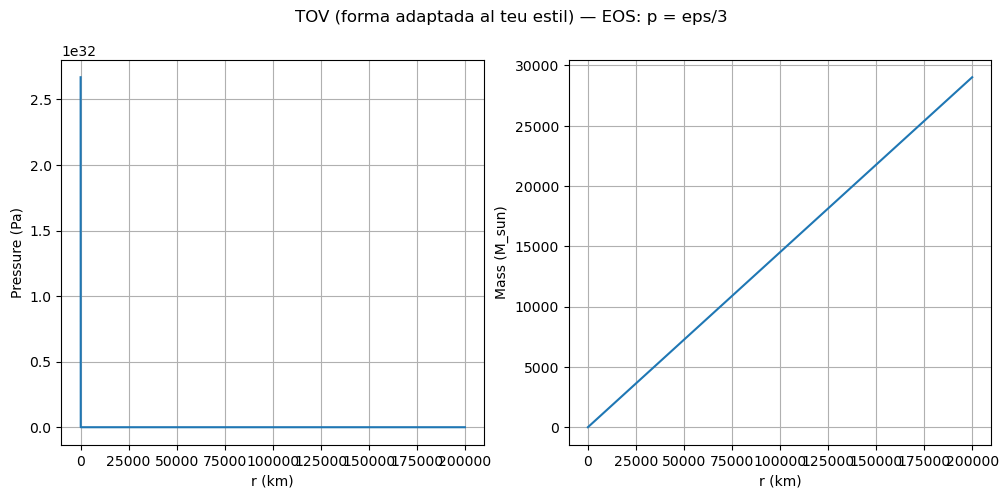

R = 200000.0 km
M(R) = 29023.700814153806 M_sun
p(R) = 1.7198055153560442e+16 Pa


In [92]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.constants import G, c, hbar, m_n, M_sun
from scipy.integrate import solve_ivp

# --------------------------
# Paràmetres i constants
# --------------------------
K_rel = 1.0 / 3.0   # p = K_rel * eps  (aquí K_rel = 1/3)
gamma = 1.0         # només per compatibilitat amb la teva estructura
# R0 usat a la teva fórmula -> radi gravitat. (G M_sun / c^2) en km
R0 = (G * M_sun / c**2).to(u.km)     # ~ 1.477 km

# Derivació analítica per ajustar les constants α, λ, β
# (s'obtenen exigint que la forma "estil-teu" coincideixi amb TOV en SI
# quan r està en km i M està en masses solars)
# alpha ha de tenir unitat de km (veure comentari a baix)
alpha = (3 * (G * M_sun / c**2)).to(u.km)   # serà multiplica per M (en M_sun) i per p/r^2
# lambda0 (es multiplica per p * r^3 / M) -> unitats 1/(Pa * km^3)
lambda0 = (4.0 * np.pi * (1e9 * u.dimensionless_unscaled) / (M_sun * c**2)).to(1/(u.km**3 * u.Pa))
# beta per dM/dr = beta * r^2 * p  (M en M_sun, r en km, p en Pa)
beta = (4.0 * np.pi * (1e9 * u.dimensionless_unscaled) * 3.0 / (M_sun * c**2)).to(1/(u.km**3 * u.Pa))

# Mostrem valors per comprovar
print("R0 =", R0)
print("alpha =", alpha)
print("lambda0 =", lambda0)
print("beta =", beta)

# --------------------------
# Equació d'estat i kF -> Pc
# --------------------------
# EOS límit (ultrarelativista): eps = 3 P  -> ja implicat en les fórmules.
# Si vols posar Pc a partir d'un k_F (fm^-1):
def Pc_from_kF_fm(kF_fm):
    """kF en fm^-1 -> pressió central en Pa per gas fermions ultra-relativista."""
    kF = (kF_fm * (1e15 / u.m)).value  # convertir a m^-1 numèric
    eps = (2.0 * hbar.value * c.value * kF**4) / (8.0 * np.pi**2)   # g=2 (spin)
    P = eps / 3.0
    return P  # J/m^3 = Pa

# Exemple: kF ~ 1 fm^-1
Pc_example = Pc_from_kF_fm(1.0)
print("Pc_example (kF=1 fm^-1) = {:.3e} Pa".format(Pc_example))

# --------------------------
# TOV seguint la teva estructura
# r en km, M en masses solars, p en Pa
# --------------------------
def TOV(r, x):
    # r: km (float)
    # x: [p (Pa), M (M_sun)]
    p, M = x
    if p <= 0 or r <= 0:
        return [0.0, 0.0]

    # Fem servir les constants ja calculades (astropy units -> .value)
    a = alpha.value       # km
    lam = lambda0.value   # 1 / (Pa * km^3)
    b = beta.value        # 1 / (Pa * km^3)
    R0val = R0.value      # km

    # Els termes tal com els tenies
    term1 = a * M * p / r**2          # units: (km * (M_sun) * Pa) / km^2 -> Pa/km (correcte)
    term2 = 4.0 / 3.0                 # ve del factor (rho + P/c^2) amb eps=3P -> 4P/c^2 -> 4/3 normalitzat
    term3 = 1.0 + lam * p * r**3 / M  # sense unitats
    term4 = 1.0 - 2.0 * R0val * M / r

    # petites defenses numèriques
    eps = 1e-12
    if term4 <= 0:
        # hem creuat l'horitzó o denominador negatiu -> aturar creixement
        return [0.0, 0.0]

    dpdr = - term1 * term2 * term3 / (term4 + eps)   # Pa per km
    dMdr = b * r**2 * p                              # dM / dr_km  (M_sun per km)

    return [dpdr, dMdr]

# Event per aturar quan p arriba a zero
def hit_surface(r, x):
    return x[0]  # pressió
hit_surface.terminal = True
hit_surface.direction = -1

# --------------------------
# Integració (estructura similar a la teva)
# --------------------------
# Valor inicial de pressió central (tria-ho amb Pc_from_kF_fm o directament)
Pc = Pc_example  # Pa  (canvia-ho segons vulguis)
# condició inicial: comensar en r0 petit (km)
r0 = 1e-6  # km (és 1e-3 m) — evita 0
# Massa inicial aproximada a petit radi (m(r) ≈ 4/3 π r^3 rho)
# recorda rho = eps / c^2 = 3P / c^2, amb r en km -> passar a metres per densitat
rho0 = (3.0 * Pc) / (c.value**2)    # kg/m^3
# m0 en kg a r0 convertit a metres
r0_m = (r0 * 1000.0)
m0_kg = 4.0/3.0 * np.pi * r0_m**3 * rho0
M0 = m0_kg / M_sun.value            # en masses solars

x_init = [Pc, M0]

r_span = (r0, 2e5)   # integrar fins 200000 km per si la solució té cua llarga (ajusta segons necessitis)
r_eval = np.linspace(r0, 2e5, 20000)

sol = solve_ivp(TOV, r_span, x_init, t_eval=r_eval, events=hit_surface, method='LSODA', rtol=1e-6, atol=1e-8, max_step=100.0)

r = sol.t
p = sol.y[0]
M = sol.y[1]

# Si l'event es va disparar, retallam a la superfície
if sol.t_events[0].size > 0:
    cutoff = np.searchsorted(r, sol.t_events[0][0])
    r = r[:cutoff+1]
    p = p[:cutoff+1]
    M = M[:cutoff+1]

# --------------------------
# Plots i resultats
# --------------------------
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(r, p)
ax1.set_xlabel('r (km)')
ax1.set_ylabel('Pressure (Pa)')
ax1.grid()
ax2.plot(r, M)
ax2.set_xlabel('r (km)')
ax2.set_ylabel('Mass (M_sun)')
ax2.grid()
fig.suptitle('TOV (forma adaptada al teu estil) — EOS: p = eps/3')
plt.show()

print("R =", r[-1], "km")
print("M(R) =", M[-1], "M_sun")
print("p(R) =", p[-1], "Pa")


In [91]:
1e35/e_0

<Quantity 0.00061887 cm3 / erg>

Newtonian solution: The pressure never gets to zero, for any integration range of r. So pressure gets infinitesimal small and mass keeps 'growing' with r. Something is off I would expect mass to stop growing after a certain r.

TOV solution: Is not working

# Find better EOS

i.e. valid for all k_f

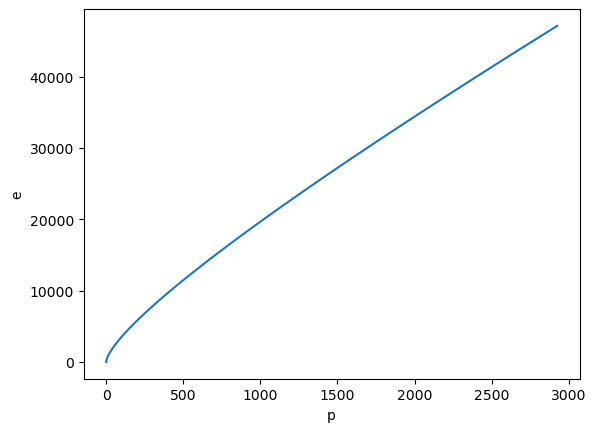

In [ ]:
#e = A_NR * p **(5/3) + A_R * p

#Find best parameters

#compute e(k_f) and p(k_f)

x = np.linspace(0, 2, 100) #k_f = x * m_n * c
n = ((x * m_n * c)**3 / (3 * np.pi **2 * hbar**3)).to('1/cm3')

e_0 = (m_n ** 4 * c ** 5 / (3 * np.pi**2 * hbar) ** 3 ).to('erg/cm3')

# ---- Energy density ----

e_x = (m_n ** 4 * c ** 5 / (8 * np.pi * hbar ** 3 ) * ((2 * x **3 + x)*(1 + x **2)**(1/2)-  np.arcsinh(x))).to('erg/cm3') #kinetik energy
e_x += n * m_n * 1 * c**2 #rest mass energy

e = e_x /e_0
# ---- Pressure ----

p_x = (m_n **4 * c ** 5 / (24 * np.pi **2 * hbar**3) * ((2 * x **3 - 3 * x) * (1 + x **2)**(1/2) + 3 * np.arcsinh(x))).to('erg/cm3')
p = p_x /e_0

# ---- Plot ----

plt.plot(p,e)
plt.xlabel('p')
plt.ylabel('e')

plt.show()


In [ ]:
# --- k_F grid ---
x = np.linspace(0.01, 5, 200)  # avoid zero (to prevent division issues)

# --- Number density n ---
n = ((x * m_n * c)**3 / (3 * np.pi **2 * hbar**3)).to('1/cm3')

# --- Normalization constant ---
e_0 = (m_n ** 4 * c ** 5 / (3 * np.pi**2 * hbar) ** 3 ).to('erg/cm3')

e_0 = 5.346e36 * u.erg / u.cm **3

# --- Energy density (kinetic + rest mass) ---
e_x = (m_n ** 4 * c ** 5 / (8 * np.pi * hbar ** 3 ) * 
       ((2 * x **3 + x) * np.sqrt(1 + x **2) - np.arcsinh(x))).to('erg/cm3')

e_x += n * m_n * c**2  # rest mass energy

e = (e_x / e_0).value

# --- Pressure ---
p_x = (m_n **4 * c ** 5 / (24 * np.pi **2 * hbar**3) * 
       ((2 * x **3 - 3 * x) * np.sqrt(1 + x **2) + 3 * np.arcsinh(x))).to('erg/cm3')
p = (p_x / e_0).value

# --- Fit function ---
def eos_model(p, A_NR, A_R):
    return A_NR * p**(3/5) + A_R * p

# --- Fit using curve_fit ---
mask = p > 0   # avoid log of negative/zero
p_fit = p[mask]
e_fit = e[mask]

params, cov = curve_fit(eos_model, p_fit, e_fit, p0=[1.0, 1.0])
A_NR, A_R = params
print("Best fit parameters:")
print(f"A_NR = {A_NR:.6f}")
print(f"A_R   = {A_R:.6f}")

# --- Plot ---
plt.figure(figsize=(7,5))
plt.plot(p, e, 'b', label='Data (from k_f)')
plt.plot(p_fit, eos_model(p_fit, *params), 'r--', label=f'Fit: A_NR={A_NR:.3f}, A_R={A_R:.3f}')
plt.xlabel("p (dimensionless)")
plt.ylabel("e (dimensionless)")
plt.legend()
plt.grid()
plt.show()


NameError: name 'curve_fit' is not defined

In [ ]:
e_0

<Quantity 5.346e+36 erg / cm3>

Vaig a afegir un markdown al codi

Vaig a afegir un segon markdown mer assegurar-me que ho se fer, i a mes, en una altra branca

holahola tercer intentt, no me nhe sortit de canviar la branca